# Quantum Kernel Estimation for a QSVC

$\blacktriangleright$ This is part **II** of a notebook series demonstrating the functionality of the <code>QMLab</code>-Package. 

[Click here to get to Part I!](./classical_learning.ipynb)

The entire progress of computing the gram matrix can be outsourced to a quantum computer. 

The rest of the support vector algorithm stays exactly the same - resulting in a hybrid algorithm.

It's called a **Q**uantum **S**upport **V**ector **C**lassifier - <code>QSVC</code> for short.

First we need **embeddings** that map our data vectors into a Hilbert space $\mathcal{H}$, the space where state vectors $\Ket{\psi}$ exist.



An **embedding** is a feature map of the form  
$$ 
\mathbf{x} \in \mathbb{R}^d \longrightarrow \Ket{\psi(\mathbf{x})} \in \mathcal{H} \tag{1}
$$
where we obtain the state vector by applying a parameterized unitary to the ground state of a quantum circuit, i.e. 
$$
\mathcal{U}(\mathbf{x}) \Ket{0} = \Ket{\psi(\mathbf{x})}.\tag{2} $$

We can obtain two different quantum states by parameterizing them with different data vectors and measure their fidelity:
$$
K_{i,j} = \left| \Braket{\psi(\mathbf{x}_j) | \psi(\mathbf{x}_i)}\right|^2 
\tag{3}
$$

We show in the paper that we get the expression for the fidelity by preparing the state 
$$
\mathcal{U}^\dagger(\mathbf{x}_j) \; \mathcal{U}(\mathbf{x}_i) \Ket{0} 
$$

and measuring the probability of measuring a bitstring only consisting of zeros, i.e. 
$$
K_{i, j} = P(measure\Ket{0}).
$$

In [39]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute

from qmlab.qsvm import QSVC
from qmlab.preprocessing import (
    parse_biomed_data_to_ndarray,
    reduce_feature_dim,
    scale_data_to_specified_range,
)
from qmlab.plotting import plot_2d_data_with_train_test_split, plot_decision_boundaries, plot_kernel_heatmap

random_state = 12345
np.random.seed(random_state)
algorithm_globals.random_seed = random_state

In [32]:
X, y = parse_biomed_data_to_ndarray("sobar_new")
X = reduce_feature_dim(X, num_features=2)
X = scale_data_to_specified_range(X, range=(-1.0, 1.0))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(57, 2)
(15, 2)
(57,)
(15,)


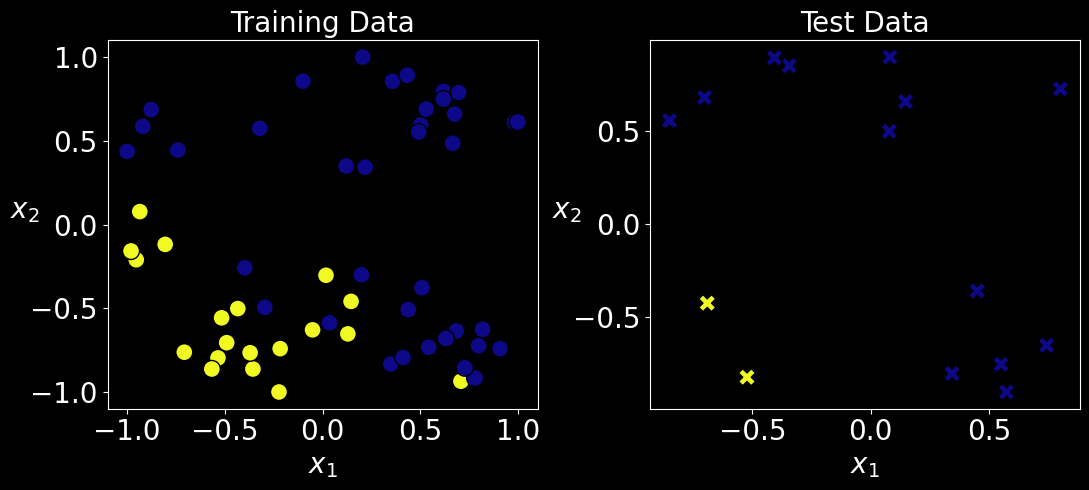

In [33]:
plot_2d_data_with_train_test_split(X_train, y_train, X_test, y_test, separate_plots=True)

Let's start by using the <code>FidelityQuantumKernel</code>-class to obtain the kernel matrix via the quantum computer:

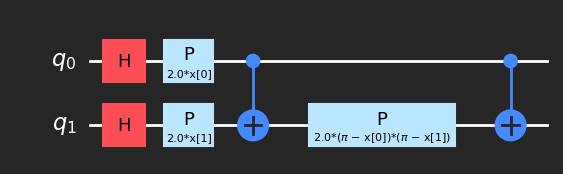

In [34]:
from sklearn.svm import SVC
from qiskit.circuit.library import ZZFeatureMap
from qmlab.kernel.fidelity_quantum_kernel import FidelityQuantumKernel

num_features = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="iqp-dark")

In [35]:
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

kernel_train = quantum_kernel.evaluate_kernel(X_train)
kernel_test = quantum_kernel.evaluate_kernel(X_test, X_train)

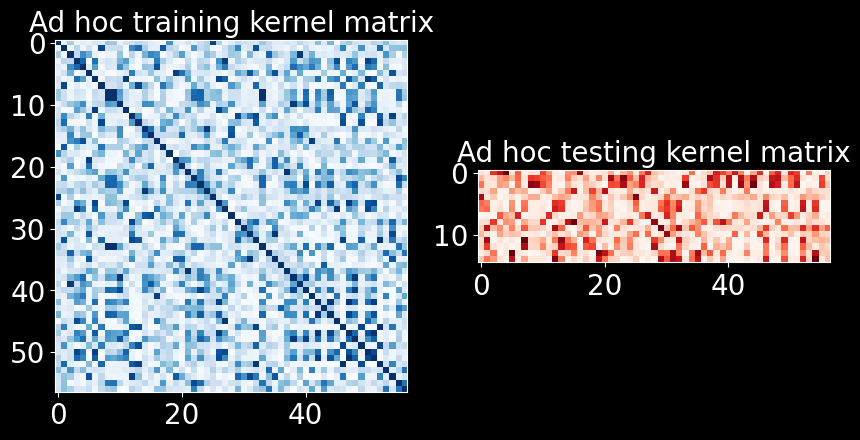

In [36]:
plot_kernel_heatmap(kernel_train, kernel_test)

In [38]:
precomputed_kernel_svc = SVC(kernel="precomputed", random_state=random_state)
precomputed_kernel_svc.fit(kernel_train, y_train)
precomputed_quantum_kernel_score = precomputed_kernel_svc.score(kernel_test, y_test)
print(f"Precomputed kernel classification score: {precomputed_quantum_kernel_score}")

Precomputed kernel classification score: 0.9333333333333333


In [37]:
y_pred = precomputed_kernel_svc.predict(kernel_test)
acc = metrics.balanced_accuracy_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_pred)
print("Prediction scores: \n")
print(f"Accuracy:\t{acc:.2f}")
print(f" ROC_AUC:\t{roc_auc:.2f}")

Prediction scores: 

Accuracy:	0.96
 ROC_AUC:	0.96


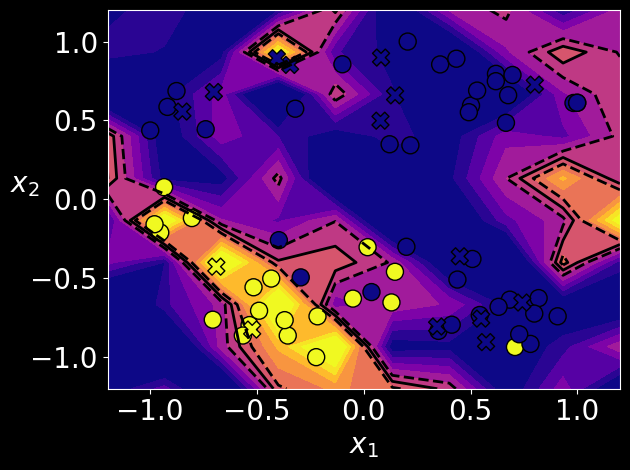

In [ ]:
fidelity = ComputeUncompute(sampler=Sampler())

qfm = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")

quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=qfm)

qsvc = QSVC(
    quantum_kernel=quantum_kernel, num_qubits=num_features, reps=2, feature_map=qfm
)
qsvc.fit(X_train, y_train)
plot_decision_boundaries(qsvc, X_train, y_train, X_test, y_test)